
# AQR: GTAA (Global Tactical Asset Allocation)

 **Prepared by Seth Huang**
 
 **April 2023**

The portfolio strategy implemented in this code resembles a few well-known investment products, such as the GTAA (Global Tactical Asset Allocation) strategy offered by Bridgewater Associates, and the Risk Parity strategy offered by AQR. Both strategies involve dynamically allocating assets across multiple asset classes based on market trends and risk characteristics, and may use leverage to increase the portfolio's risk-adjusted returns. However, it's important to note that the specific implementation and performance of these strategies can vary widely depending on the investment manager and their approach.

The defined ETFs and S&P 500 index symbol in this code snippet represent different types of assets and indexes for constructing a diversified portfolio. Let's take a closer look at each of them:

**equity_etfs**: These are equity-based ETFs that represent different regions or markets:

- **SPY**: This ETF tracks the S&P 500 Index, which consists of the 500 largest publicly traded companies in the U.S. It's a popular choice for U.S. large-cap equity exposure.
- **EFA**: This ETF tracks the MSCI EAFE Index, which consists of large and mid-cap companies from developed markets in Europe, Australasia, and the Far East. It's commonly used for developed market international equity exposure outside of North America.
- **EEM**: This ETF tracks the MSCI Emerging Markets Index, which consists of large and mid-cap companies from emerging market countries. It's a popular choice for gaining exposure to equity from developing economies.

**debt_etfs**: These are fixed income or bond-based ETFs that represent different bond types and durations:

- **AGG**: This ETF tracks the Bloomberg Barclays U.S. Aggregate Bond Index, which includes U.S. government bonds, investment-grade corporate bonds, and mortgage-backed securities. It's a popular choice for broad U.S. bond market exposure.
- **IEF**: This ETF tracks the ICE U.S. Treasury 7-10 Year Bond Index, which includes U.S. Treasury bonds with a remaining maturity of 7 to 10 years. It's suitable for gaining exposure to intermediate-term U.S. government bonds.
- **EMB**: This ETF tracks the J.P. Morgan EMBI Global Core Index, which consists of U.S. dollar-denominated emerging market bonds. It's a popular choice for gaining exposure to the fixed income of emerging market countries.

**sp500_symbol**: `^GSPC` is the symbol for the S&P 500 Index, which is a popular benchmark for the U.S. stock market. It consists of the 500 largest publicly traded companies in the U.S. and is widely used to measure the performance of U.S. large-cap equities.

The variables equity_etfs, high_yield_bond_etf, high_dividend_yield_etf, debt_etfs, gold_etf, energy_etf, and sp500_symbol are all strings representing the tickers (or symbols) of various exchange-traded funds (ETFs) and stock market indices. Here's a brief description of each one:

equity_etfs: a list of three ETFs that track different segments of the U.S. stock market. Specifically, SPY is the SPDR S&P 500 ETF Trust, which tracks the S&P 500 Index; VEIEX is the Vanguard Emerging Markets Stock Index Fund, which tracks the MSCI Emerging Markets Index; and VYM is the Vanguard High Dividend Yield ETF, which tracks the FTSE High Dividend Yield Index.

high_yield_bond_etf: a string representing the ticker of a high-yield bond ETF, specifically VWEHX, which is the Vanguard High-Yield Corporate Fund.

high_dividend_yield_etf: a string representing the ticker of a high-dividend-yield ETF, specifically VHDYX, which is the Vanguard High Dividend Yield Index Fund.

debt_etfs: a list of three ETFs that track different segments of the U.S. bond market. Specifically, VBMFX is the Vanguard Total Bond Market Index Fund, which tracks the Bloomberg Barclays U.S. Aggregate Bond Index; VUSTX is the Vanguard Long-Term Treasury Fund, which tracks the Bloomberg Barclays U.S. Long Treasury Index; and PREMX is the PIMCO Real Return Fund, which invests in a diversified portfolio of inflation-indexed bonds.

gold_etf: a string representing the ticker of a gold ETF, specifically GLD, which is the SPDR Gold Shares ETF.

energy_etf: a string representing the ticker of an energy ETF, specifically GSG, which is the iShares S&P GSCI Commodity-Indexed Trust.

sp500_symbol: a string representing the ticker of the S&P 500 Index, specifically '^GSPC'. The S&P 500 is a stock market index that tracks the performance of 500 large-cap companies listed on U.S. stock exchanges.

[*********************100%***********************]  6 of 6 completed


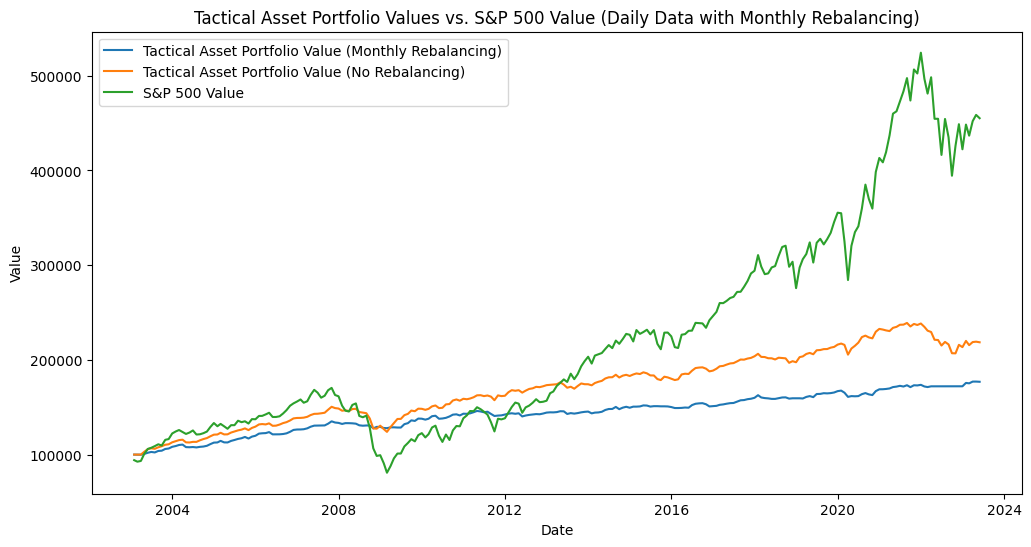

In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import cvxpy as cp


# Set this flag to True to short assets if their prices are under the moving average
short_if_under_moving_average = False

# Define the time range
start_date = '2003-01-01'
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

equity_etfs = ['SPY', 'VEIEX']
#high_yield_bond_etf = 'VWEHX'
#high_dividend_yield_etf = 'VYM'
debt_etfs = ['VBMFX', 'VUSTX', 'PREMX']
#gold_etf = 'GLD'
#energy_etf = 'GSG'
sp500_symbol = '^GSPC'

# Download the adjusted close prices
prices = yf.download(equity_etfs  + debt_etfs + [sp500_symbol], start=start_date, end=end_date)['Adj Close']
prices = prices.dropna()

# Calculate the 200-day exponential moving average for each ETF
span = 150
moving_averages = prices.ewm(span=span, adjust=False).mean()

# Calculate the signals (1 if above 200-day MA, 0 if below)
signals = (prices > moving_averages + moving_averages*0.01).astype(int)

if short_if_under_moving_average:
    signals = signals.replace(0, -1)

# Resample the signals to the end of the month
monthly_signals = signals.resample('M').last()
monthly_signals = monthly_signals.shift(1)

# Calculate the daily returns
daily_returns = prices.pct_change()

# Resample the daily returns to the end of the month
monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

# Initialize weights DataFrame
weights = pd.DataFrame(index=monthly_signals.index, columns=monthly_signals.columns)


# Calculate the weights
num_equity_etfs = len(equity_etfs) + 3  # Add 1 for the energy ETF, 1 for high-yield bond ETF, and 1 for high-dividend-yield ETF
num_debt_etfs = len(debt_etfs) + 1  # Add 1 for the gold ETF
equity_weights = 0.6 / num_equity_etfs
debt_weights = 0.4 / num_debt_etfs
weights[equity_etfs] = equity_weights
weights[debt_etfs] = debt_weights
#weights[gold_etf] = debt_weights
#weights[energy_etf] = equity_weights
#weights[high_yield_bond_etf] = equity_weights
#weights[high_dividend_yield_etf] = equity_weights

# Apply the signals to the weights
weighted_signals = weights * monthly_signals
weighted_signals


# Calculate the daily returns
daily_returns = prices.pct_change()

# Resample the daily returns to the end of the month
monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

# Calculate the weighted returns
weighted_returns = weighted_signals.shift(1) * monthly_returns

# Calculate the portfolio returns
portfolio_returns = weighted_returns.sum(axis=1)

# Calculate the portfolio value over time
initial_investment = 100000
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment


# Calculate the non-rebalancing weighted returns
non_rebalancing_weighted_signals = weights 
non_rebalancing_weighted_returns = non_rebalancing_weighted_signals.shift(1) * monthly_returns

# Calculate the non-rebalancing portfolio returns
non_rebalancing_portfolio_returns = non_rebalancing_weighted_returns.sum(axis=1)

# Calculate the non-rebalancing portfolio value over time
non_rebalancing_portfolio_value = (1 + non_rebalancing_portfolio_returns).cumprod() * initial_investment


# Calculate the S&P 500 returns and value over time
sp500_returns = monthly_returns[sp500_symbol]
sp500_value = (1 + sp500_returns).cumprod() * initial_investment

# Plot the Tactical Asset Portfolio Value and S&P 500 value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Tactical Asset Portfolio Value (Monthly Rebalancing)')
plt.plot(non_rebalancing_portfolio_value, label='Tactical Asset Portfolio Value (No Rebalancing)')
plt.plot(sp500_value, label='S&P 500 Value')
plt.title('Tactical Asset Portfolio Values vs. S&P 500 Value (Daily Data with Monthly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()




In [29]:
# Calculate the monthly returns for the portfolio
monthly_portfolio_returns = portfolio_returns.resample('M').sum()

# Calculate the number of profitable months
profitable_months = len(monthly_portfolio_returns[monthly_portfolio_returns > 0])

# Calculate the total number of months
total_months = len(monthly_portfolio_returns)

# Calculate the percentage of profitable months
percentage_profitable_months = profitable_months / total_months * 100

# Calculate the number of profitable years
yearly_portfolio_returns = portfolio_returns.resample('Y').sum()
profitable_years = len(yearly_portfolio_returns[yearly_portfolio_returns > 0])

# Calculate the total number of years
total_years = len(yearly_portfolio_returns)

# Calculate the percentage of profitable years
percentage_profitable_years = profitable_years / total_years * 100

print(f"Percentage of profitable months: {percentage_profitable_months:.2f}%")
print(f"Percentage of profitable years: {percentage_profitable_years:.2f}%")

Percentage of profitable months: 63.67%
Percentage of profitable years: 80.95%


### SP500 profitable months and years

In [31]:
monthly_sp500_returns = sp500_returns.resample('M').sum()
profitable_sp500_months = len(monthly_sp500_returns[monthly_sp500_returns > 0])
total_months = len(monthly_sp500_returns)
percentage_profitable_sp500_months = profitable_sp500_months / total_months * 100
yearly_sp500_returns = sp500_returns.resample('Y').sum()
profitable_sp500_years = len(yearly_sp500_returns[yearly_sp500_returns > 0])
total_years = len(yearly_sp500_returns)
percentage_profitable_sp500_years = profitable_sp500_years / total_years * 100

print(f"Percentage of profitable months for S&P 500: {percentage_profitable_sp500_months:.2f}%")
print(f"Percentage of profitable years for S&P 500: {percentage_profitable_sp500_years:.2f}%")

Percentage of profitable months for S&P 500: 64.90%
Percentage of profitable years for S&P 500: 85.71%


In [33]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the portfolio value trace
fig.add_trace(go.Scatter(x=portfolio_value.index, y=portfolio_value.values,
                         mode='lines',
                         name='Tactical Asset Portfolio Value (Monthly Rebalancing)'))

# Add the non-rebalancing portfolio value trace
fig.add_trace(go.Scatter(x=non_rebalancing_portfolio_value.index, y=non_rebalancing_portfolio_value.values,
                         mode='lines',
                         name='Tactical Asset Portfolio Value (No Rebalancing)'))

# Add the S&P 500 value trace
fig.add_trace(go.Scatter(x=sp500_value.index, y=sp500_value.values,
                         mode='lines',
                         name='S&P 500 Value'))

# Set the layout properties
fig.update_layout(title='Tactical Asset Portfolio Values vs. S&P 500 Value (Daily Data with Monthly Rebalancing)',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0.7)',
                  font=dict(color='white'))

# Show the plot
fig.show()


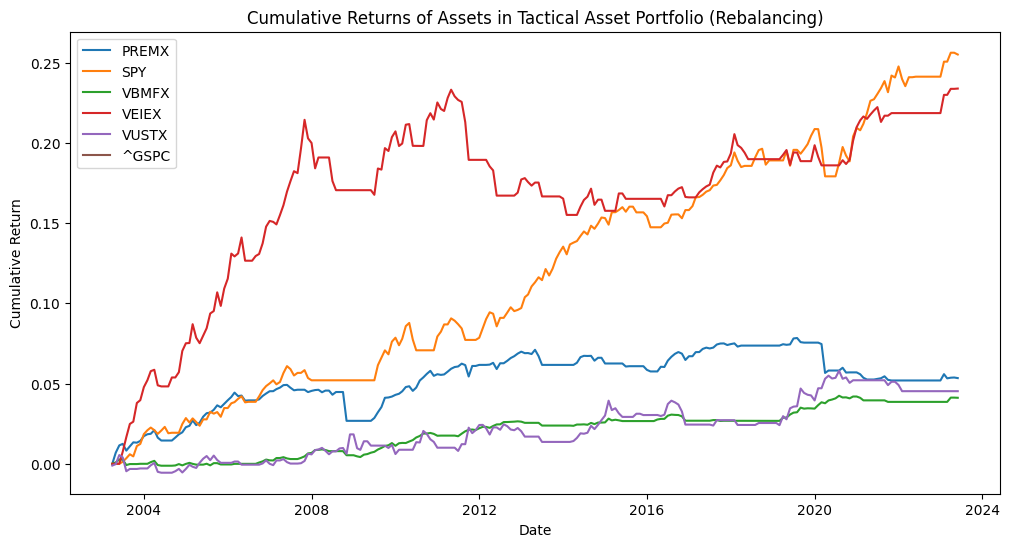

In [34]:
# Calculate the cumulative returns of each asset in the rebalancing portfolio
cumulative_returns = (1 + weighted_returns).cumprod() - 1

# Plot the cumulative returns of each asset in the rebalancing portfolio
plt.figure(figsize=(12, 6))
for asset in weighted_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[asset], label=asset)
plt.title('Cumulative Returns of Assets in Tactical Asset Portfolio (Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [35]:
import plotly.graph_objs as go

# Calculate the cumulative returns of each asset in the rebalancing portfolio
cumulative_returns = (1 + weighted_returns).cumprod() - 1

# Create a list of traces for each asset's cumulative returns
traces = []
for asset in weighted_returns.columns:
    trace = go.Scatter(
        x=cumulative_returns.index,
        y=cumulative_returns[asset],
        mode='lines',
        name=asset
    )
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Cumulative Returns of Assets in Tactical Asset Portfolio (Rebalancing)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Return'),
    template='plotly_dark'
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)
fig.show()




In [36]:
# Calculate the S&P 500 annualized returns, volatility, and Sharpe ratio
sp500_annualized_returns = np.mean(sp500_returns) * 12
sp500_annualized_volatility = np.std(sp500_returns) * np.sqrt(12)
sp500_sharpe_ratio = sp500_annualized_returns / sp500_annualized_volatility

# Calculate the S&P 500 max drawdown
sp500_max_drawdown = (sp500_value / sp500_value.cummax() - 1).min()

# Calculate the turnover for the tactical asset portfolio
turnover = (signals.diff().abs().sum().sum()) / signals.shape[0]

# Calculate the non-rebalancing portfolio annualized returns, volatility, and Sharpe ratio
non_rebalancing_annualized_returns = np.mean(non_rebalancing_portfolio_returns) * 12
non_rebalancing_annualized_volatility = np.std(non_rebalancing_portfolio_returns) * np.sqrt(12)
non_rebalancing_sharpe_ratio = non_rebalancing_annualized_returns / non_rebalancing_annualized_volatility

# Calculate the non-rebalancing portfolio max drawdown
non_rebalancing_max_drawdown = (non_rebalancing_portfolio_value / non_rebalancing_portfolio_value.cummax() - 1).min()

# Calculate the Tactical Asset Portfolio (Rebalancing) annualized returns, volatility, and Sharpe ratio
rebalancing_annualized_returns = np.mean(portfolio_returns) * 12
rebalancing_annualized_volatility = np.std(portfolio_returns) * np.sqrt(12)
rebalancing_sharpe_ratio = (rebalancing_annualized_returns) / rebalancing_annualized_volatility

# Calculate the Tactical Asset Portfolio (Rebalancing) max drawdown
rebalancing_max_drawdown = (portfolio_value / portfolio_value.cummax() - 1).min()

# Create a DataFrame for the metrics
metrics = pd.DataFrame({
    'Tactical Asset Portfolio (Rebalancing)': [rebalancing_annualized_returns, rebalancing_annualized_volatility, rebalancing_sharpe_ratio, rebalancing_max_drawdown, turnover],
    'Tactical Asset Portfolio (No Rebalancing)': [non_rebalancing_annualized_returns, non_rebalancing_annualized_volatility, non_rebalancing_sharpe_ratio, non_rebalancing_max_drawdown, 0],
    'S&P 500': [sp500_annualized_returns, sp500_annualized_volatility, sp500_sharpe_ratio, sp500_max_drawdown, np.nan]
}, index=['Annualized Returns', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Turnover'])

# Display the metrics table
metrics

,Tactical Asset Portfolio (Rebalancing),Tactical Asset Portfolio (No Rebalancing),S&P 500
Annualized Returns,0.028417,0.039650,0.085431
Annualized Volatility,0.030005,0.050566,0.147147
Sharpe Ratio,0.947080,0.784125,0.580586
Max Drawdown,-0.054861,-0.176071,-0.525559
Turnover,0.266784,0.000000,NaN


# Let's see if, with a fine control of risks and lessons learned from the data, we can now leverage up (in a Bridgewater fasion)

To leverage up the tactical asset portfolios (rebalancing and non-rebalancing) to have the same volatility as the S&P 500, \
you can calculate the leverage factor for each portfolio by dividing the S&P 500's volatility by each portfolio's volatility. \
Then, apply the leverage factor to the respective portfolio returns, calculate the new portfolio values, and recompute the metrics.



In [37]:
# Calculate the leverage factors
rebalancing_leverage_factor = sp500_annualized_volatility / rebalancing_annualized_volatility
non_rebalancing_leverage_factor = sp500_annualized_volatility / non_rebalancing_annualized_volatility

# Apply the leverage factors to the portfolio returns
leveraged_rebalancing_portfolio_returns = portfolio_returns * rebalancing_leverage_factor
leveraged_non_rebalancing_portfolio_returns = non_rebalancing_portfolio_returns * non_rebalancing_leverage_factor

# Calculate the leveraged portfolio values over time
leveraged_rebalancing_portfolio_value = (1 + leveraged_rebalancing_portfolio_returns).cumprod() * initial_investment
leveraged_non_rebalancing_portfolio_value = (1 + leveraged_non_rebalancing_portfolio_returns).cumprod() * initial_investment

# Compute the new metrics for the leveraged portfolios
leveraged_rebalancing_annualized_returns = np.mean(leveraged_rebalancing_portfolio_returns) * 12
leveraged_rebalancing_annualized_volatility = np.std(leveraged_rebalancing_portfolio_returns) * np.sqrt(12)
leveraged_rebalancing_sharpe_ratio = leveraged_rebalancing_annualized_returns / leveraged_rebalancing_annualized_volatility
leveraged_rebalancing_max_drawdown = (leveraged_rebalancing_portfolio_value / leveraged_rebalancing_portfolio_value.cummax() - 1).min()

leveraged_non_rebalancing_annualized_returns = np.mean(leveraged_non_rebalancing_portfolio_returns) * 12
leveraged_non_rebalancing_annualized_volatility = np.std(leveraged_non_rebalancing_portfolio_returns) * np.sqrt(12)
leveraged_non_rebalancing_sharpe_ratio = leveraged_non_rebalancing_annualized_returns / leveraged_non_rebalancing_annualized_volatility
leveraged_non_rebalancing_max_drawdown = (leveraged_non_rebalancing_portfolio_value / leveraged_non_rebalancing_portfolio_value.cummax() - 1).min()

# Update the metrics DataFrame with the leveraged portfolio metrics
metrics['Leveraged Tactical Asset Portfolio (Rebalancing)'] = [leveraged_rebalancing_annualized_returns, leveraged_rebalancing_annualized_volatility, leveraged_rebalancing_sharpe_ratio, leveraged_rebalancing_max_drawdown, turnover]
metrics['Leveraged Tactical Asset Portfolio (No Rebalancing)'] = [leveraged_non_rebalancing_annualized_returns, leveraged_non_rebalancing_annualized_volatility, leveraged_non_rebalancing_sharpe_ratio, leveraged_non_rebalancing_max_drawdown, 0]

# Print the updated metrics DataFrame
metrics

,Tactical Asset Portfolio (Rebalancing),Tactical Asset Portfolio (No Rebalancing),S&P 500,Leveraged Tactical Asset Portfolio (Rebalancing),Leveraged Tactical Asset Portfolio (No Rebalancing)
Annualized Returns,0.028417,0.039650,0.085431,0.139360,0.115381
Annualized Volatility,0.030005,0.050566,0.147147,0.147147,0.147147
Sharpe Ratio,0.947080,0.784125,0.580586,0.947080,0.784125
Max Drawdown,-0.054861,-0.176071,-0.525559,-0.249012,-0.449565
Turnover,0.266784,0.000000,NaN,0.266784,0.000000


In [181]:
np.where(leveraged_rebalancing_portfolio_returns.values<-0.05)

(array([ 12,  42,  58,  66,  79,  86,  94, 120, 135, 143, 150, 159, 160,
        166]),)

In [164]:
rebalancing_leverage_factor

3.532521812729567

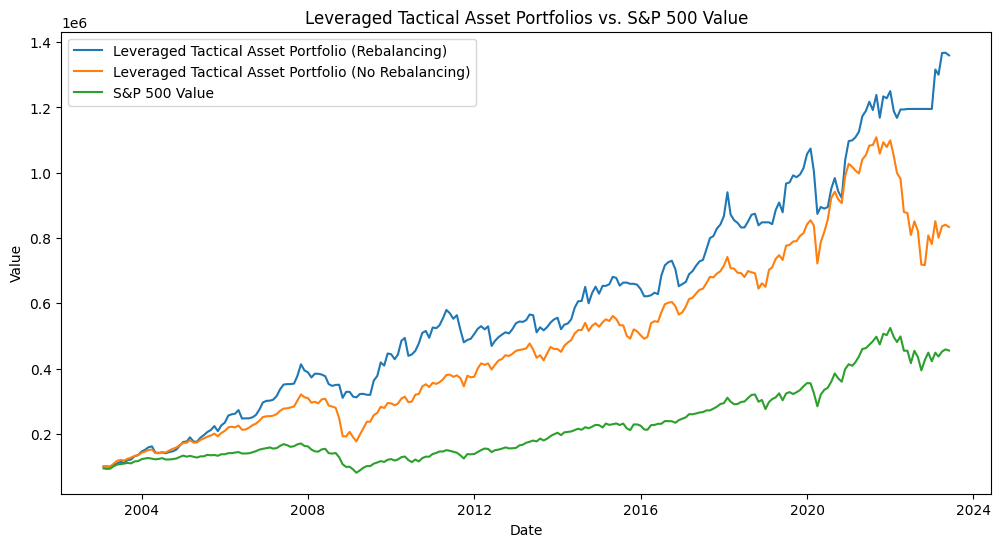

In [38]:
# Plot the S&P 500, Leveraged Tactical Asset Portfolio (Rebalancing), and Leveraged Tactical Asset Portfolio (No Rebalancing) values over time
plt.figure(figsize=(12, 6))
plt.plot(leveraged_rebalancing_portfolio_value, label='Leveraged Tactical Asset Portfolio (Rebalancing)')
plt.plot(leveraged_non_rebalancing_portfolio_value, label='Leveraged Tactical Asset Portfolio (No Rebalancing)')
plt.plot(sp500_value, label='S&P 500 Value')
plt.title('Leveraged Tactical Asset Portfolios vs. S&P 500 Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [152]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the portfolio value trace
fig.add_trace(go.Scatter(x=leveraged_rebalancing_portfolio_value.index, y=leveraged_rebalancing_portfolio_value.values,
                         mode='lines',
                         name='Leveraged Tactical Asset Portfolio Value (Monthly Rebalancing)'))

# Add the non-rebalancing portfolio value trace
fig.add_trace(go.Scatter(x=leveraged_non_rebalancing_portfolio_value.index, y=leveraged_non_rebalancing_portfolio_value.values,
                         mode='lines',
                         name='Leveraged Tactical Asset Portfolio Value (No Rebalancing)'))

# Add the S&P 500 value trace
fig.add_trace(go.Scatter(x=sp500_value.index, y=sp500_value.values,
                         mode='lines',
                         name='S&P 500 Value'))

# Set the layout properties
fig.update_layout(title='Tactical Asset Portfolio Values vs. S&P 500 Value (Daily Data with Monthly Rebalancing)',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0.7)',
                  font=dict(color='white'))

# Show the plot
fig.show()


## ML Implementation

In [91]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


# Set this flag to True to short assets if their prices are under the moving average
short_if_under_moving_average = False

# Define the time range
start_date = '2000-01-01'
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

equity_etfs = ['SPY', 'VEIEX', 'VYM']
high_yield_bond_etf = 'VWEHX'
high_dividend_yield_etf = 'VHDYX'
debt_etfs = ['VBMFX', 'VUSTX', 'PREMX']
gold_etf = 'GLD'
energy_etf = 'GSG'
sp500_symbol = '^GSPC'

# Download the adjusted close prices
prices = yf.download(equity_etfs + debt_etfs + [gold_etf, energy_etf, sp500_symbol], start=start_date, end=end_date)['Adj Close']
prices = prices.dropna()

# Calculate the 200-day moving average for each ETF
moving_averages = prices.rolling(window=200).mean()

# Calculate the signals (1 if above 200-day MA, 0 if below)
signals = (prices > moving_averages + moving_averages*0.05 ).astype(int)

if short_if_under_moving_average:
    signals = signals.replace(0, -1)

# Resample the signals to the end of the month
monthly_signals = signals.resample('M').last()
monthly_signals = monthly_signals.shift(1)

# Calculate the daily returns
daily_returns = prices.pct_change()

# Resample the daily returns to the end of the month
monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

# Initialize weights DataFrame
weights = pd.DataFrame(index=monthly_signals.index, columns=monthly_signals.columns)

# Define the machine learning model and features
model = LogisticRegression()
features = pd.DataFrame(index=monthly_returns.index, columns=['ma_signal', 'ma_signal_lag1'])

# Iterate over each asset and perform walk-forward validation
for asset in monthly_signals.columns:
    # Merge the signals and returns for the current asset
    data = pd.concat([monthly_signals[asset], monthly_returns[asset]], axis=1)
    data.columns = ['signal', 'return']
    
    # Create the additional features
    data['ma_signal_lag1'] = data['signal'].shift(1)
    
    # Split the data into training and testing sets
    train_size = int(len(data) * 0.2)
    
    # Iterate over each period and perform walk-forward validation
    for i in range(train_size, len(data)-1):
        # Split the data into training and testing sets for the current period
        train_data = data.iloc[:i]
        test_data = data.iloc[i:i+2]
        
        # If the signal changes, fit the machine learning model on the training data and make a prediction for the next period
        if train_data['signal'].iloc[-1] != train_data['signal'].iloc[-2]:
            X_train = train_data[['signal', 'ma_signal_lag1']]
            y_train = (train_data['return'] > 0).astype(int)
            model.fit(X_train, y_train)
        
            X_test = test_data[['signal', 'ma_signal_lag1']]
            y_pred = model.predict(X_test)
            
            # If the signal changes from 0 to 1 and the model predicts a positive return, enter the market
            if test_data['signal'].iloc[-1] == 1 and y_pred[-1] == 1:
                weights.loc[test_data.index[-1], asset] = 0.6 / (len(equity_etfs) + 3)
            # If the signal changes from 0 to 1 and the model predicts a negative return, short the asset
            elif test_data['signal'].iloc[-1] == 1 and y_pred[-1] == 0:
                weights.loc[test_data.index[-1], asset] = -0.6 / (len(equity_etfs) + 3)
            # If the signal changes from 1 to 0 and the model predicts a positive return, exit the market
            elif test_data['signal'].iloc[-1] == 0 and y_pred[-1] == 1:
                weights.loc[test_data.index[-1], asset] = -0.6 / (len(equity_etfs) + 3)
            # If the signal changes from 1 to 0 and the model predicts a negative return, exit the market and short the asset
            elif test_data['signal'].iloc[-1] == 0 and y_pred[-1] == 0:
                weights.loc[test_data.index[-1], asset] = 0.6 / (len(equity_etfs) + 3)
        
        # If the signal doesn't change, use the previous weights
        else:
            weights.loc[test_data.index[-1], asset] = weights.loc[train_data.index[-1], asset]

weighted_signals = weights * monthly_signals

weighted_returns = weighted_signals.shift(1) * monthly_returns

portfolio_returns = weighted_returns.sum(axis=1)

initial_investment = 100000
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

sp500_returns = monthly_returns[sp500_symbol]
sp500_value = (1 + sp500_returns).cumprod() * initial_investment

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Tactical Asset Portfolio Value (Monthly Rebalancing)')
plt.plot(sp500_value, label='S&P 500 Value')
plt.title('Tactical Asset Portfolio Values vs. S&P 500 Value (Daily Data with Monthly Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

[*********************100%***********************]  9 of 9 completed


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Development May 11, 2023 (Starting here to clean stuff up)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import talib

In [2]:
# Define the time range
start_date = '2000-01-01'
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

equity_etfs = ['SPY', 'VEIEX', 'VYM']
high_yield_bond_etf = 'VWEHX'
high_dividend_yield_etf = 'VHDYX'
debt_etfs = ['VBMFX', 'VUSTX', 'PREMX']
gold_etf = 'GLD'
energy_etf = 'GSG'
sp500_symbol = '^GSPC'

# Download the adjusted close prices
asset_prices = yf.download(equity_etfs + debt_etfs + [gold_etf, energy_etf, sp500_symbol], start=start_date, end=end_date)['Adj Close']
asset_prices = asset_prices.dropna()

[*********************100%***********************]  9 of 9 completed


pseudo_code

for i in range(len(df)):
    if the date == end_of_month_date:
        signal = 1 if price > price_10_months_moving_average else 0

        if signal == 0:
            feature_engineered_df = get_features(df)
            train_data = feature_engineered_df[0:0.8*(len(feature_engineered))]
            train_y = feature_engineered_df[0:0.8*(len(feature_engineered))]['return'].shift(-1)
            model = RandomForestClf()
            model.fit(train_data, train_y)

            prediction = model.predict(test_data)
        
            if prediction == 1:
                weight_asset = 1
            else:
                weight_asset = 0 # or exit part of it

        


In [17]:
asset_prices[asset]

Date
2006-11-16     61.310001
2006-11-17     61.779999
2006-11-20     61.770000
2006-11-21     62.270000
2006-11-22     62.500000
                 ...    
2023-05-05    187.460007
2023-05-08    187.690002
2023-05-09    189.020004
2023-05-10    188.750000
2023-05-11    187.130005
Name: GLD, Length: 4148, dtype: float64

In [ ]:
using_machine_learning = False

# Initialize weights DataFrame
weights = pd.DataFrame(index=asset_prices.index, columns=asset_prices.columns)
asset_returns = pd.DataFrame(index=asset_prices.index, columns=asset_prices.columns)

for asset in asset_prices.columns:
    # Iterate over each period and perform walk-forward validation
    close_prices = asset_prices[asset]
    dates = close_prices.index
    for i in range(300, len(close_prices)-30):
        if dates[i].is_month_end:
            # if we have last month's signal (weight[asset].iloc[-2])
            if len(weights)>1: 
                if weights[asset].iloc[-2] == 1: # if last month's signal is 1, meaning staying in the market
                    # get the return 
                    asset_returns.loc[close_prices.index[i], asset] = (close_prices[i]-close_prices[i-22])/close_prices[i-22]
                else:
                    asset_returns.loc[close_prices.index[i], asset] = 0

        else:
            if len(weights)>1:
                asset_returns.loc[close_prices.index[i], asset] = 0

            long_term_ema = close_prices[asset].iloc[i-160:i+1].ewm(span=150).mean()
            price = close_prices[asset].iloc[i]
            if price < long_term_ema.iloc[-1]:
                if using_machine_learning == False:
                    weights.loc[close_prices.index[i], asset] = 0



                # else:
                #     # Define the machine learning model and features
                #     model = LogisticRegression()
                #     features = pd.DataFrame(index=monthly_returns.index, columns=['ma_signal', 'ma_signal_lag1', 'rsi', 'stoch', 'macd'])
                #     # Conduct feature engineering
                #     close_prices = prices[[asset]].fillna(method='ffill')
                #     close_prices['SMA'] = talib.SMA(close_prices[asset].values, timeperiod=14)
                #     close_prices['RSI'] = talib.RSI(close_prices[asset].values, timeperiod=14)
                #     close_prices['MACD'] = talib.MACD(close_prices[asset].values, fastperiod=12, slowperiod=26, signalperiod=9)[0]
                #     close_prices['EMA'] = talib.EMA(close_prices[asset].values, timeperiod=20)
                #     close_prices['STOCHRSI'] = talib.STOCHRSI(close_prices[asset].values, timeperiod=14)[0]
                #     #close_prices['ADOSC'] = talib.ADOSC(close_prices['High'], close_prices['Low'], close_prices[asset], close_prices['Volume'], fastperiod=3, slowperiod=10)    
                #     # Split the data into training and testing sets
                #     train_size = int(len(data) * 0.2)
        
                #     train_data = close_prices.iloc[i-300:i]
                #     test_data = close_prices.iloc[i-300:i+2]
                #     print(f'training ends at {train_data.index[-1]}') 
                #     print(f'predicting the return for {test_data.index[-1]}') 

            else:
                weights.loc[close_prices.index[10], asset] = 1

                    # here we get the monthly returns and record the turnover

                    # If the signal changes, fit the machine learning model on the training data and make a prediction for the next period
                    # if train_data['signal'].iloc[-1] != train_data['signal'].iloc[-2]:
                    #     X_train = train_data[['signal', 'ma_signal_lag1'] + [f'ti_{j}' for j in range(num_features)]]
                    #     y_train = (train_data['return'] > 0).astype(int)
                    #     model.fit(X_train, y_train)
                    
                    #     X_test = test_data[['signal', 'ma_signal_lag1'] + [f'ti_{j}' for j in range(num_features)]]
                    #     y_pred = model.predict(X_test)
                        
                    #     # If the signal changes from 0 to 1 and the model predicts a positive return, enter the market
                    #     if test_data['signal'].iloc[-1] == 1 and y_pred[-1] == 1:
                    #         weights.loc[test_data.index[-1], asset] = 0.6 / (len(equity_etfs) + 3)
                    #     # If the signal changes from 0 to 1 and the model predicts a negative return, short the asset
                    #     elif test_data['signal'].iloc[-1] == 1 and y_pred[-1] == 0:
                    #         weights.loc[test_data.index[-1], asset] = -0.6 / (len(equity_etfs) + 3)
                    #     # If the signal changes from 1 to 